# Fifa's players


##### Install and import library

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import os
#import sys
#!{sys.executable} -m pip install plotly
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install seaborn
import seaborn as sb
import pandas as pd
import numpy as np 
import matplotlib as mlt
import matplotlib.pyplot as plt
import re
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler 
from pyspark.ml.feature import RobustScaler



## Create SparkContext

In [2]:
spark = SparkSession.builder.appName("linear_regression").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/28 00:42:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc = spark.sparkContext

In [4]:
sc

<SparkContext master=local[*] appName=linear_regression>

## Load the csv file (fifa_data.csv)

In [5]:
dname = "fifa22_data_.csv"
datapath = "/Users/leochessa/Desktop/DSBAI/Armano/dataset_project"

In [6]:
fifa_data = spark.read.csv(os.path.join(datapath,dname), inferSchema=True, header=True) 

## Observing dataset

In [7]:
fifa_data.show(10,truncate=False) 
fifa_data.count()



22/06/28 00:42:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+------------------------------------------------------------------+-----------------+-----------------------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+------------+-------------------+----------------------+------------+-------------+------------------+----------------+-----------+-------------------------+--------------+----------------+--------------+---------------+--------------------+--------------+---------+-----------+------------------------+-------------+---------+---------+------------------+-------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+------

19239

#### Vediamo che il dataset presenta 19239 osservazioni e 110 variabili


In [8]:
fifa_data.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: string (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_id: integer (nullable = tru

#### Osservo la correlazione lineare tra le variabili

# Drop Unnecessary Columns

### In base alla correlazione ed alla natura delle variabili inizio ad eliminarne

In [8]:
fifa_data_new=fifa_data.drop("dob","sofifa_id","player_url",
                             "nation_jersey_number","long_name","club_team_id",
                             "club_jersey_number","club_loaned_from","nationality_id",
                             "nation_team_id","real_face","body_type","player_face_url",
                             "club_logo_url","club_flag_url","nation_logo_url","nation_flag_url")

In [9]:
fifa_data_new.printSchema()

root
 |-- short_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_name: string (nullable = true)
 |-- nation_position: string (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- release_clause_eu

## Changing economic values in K

### Riduco in multipli di mille i valori economici per ridurne la variabilità

In [10]:
fifa_data_new = fifa_data_new.withColumn('Value_in_K', fifa_data["value_eur"]/1000)
fifa_data_new = fifa_data_new.withColumn('Wage_in_K', fifa_data["wage_eur"]/1000)
fifa_data_new = fifa_data_new.withColumn('Release_clause_in_K', fifa_data["release_clause_eur"]/1000)

fifa_data_new=fifa_data_new.drop("value_eur","wage_eur","release_clause_eur")

In [11]:
fifa_data_new.columns

['short_name',
 'player_positions',
 'overall',
 'potential',
 'age',
 'height_cm',
 'weight_kg',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_joined',
 'club_contract_valid_until',
 'nationality_name',
 'nation_position',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'men

In [12]:
fifa_data_new.describe(["potential","overall","Value_in_K","Wage_in_K","Release_clause_in_K"]).show()

+-------+------------------+-----------------+-----------------+------------------+-------------------+
|summary|         potential|          overall|       Value_in_K|         Wage_in_K|Release_clause_in_K|
+-------+------------------+-----------------+-----------------+------------------+-------------------+
|  count|             19239|            19239|            19165|             19178|              18063|
|   mean| 71.07937002962731|65.77218150631529|2850.451813201148|  9.01798936281156|  5374.044123346067|
| stddev|6.0862131012609035|  6.8802315068618|7613.699947458985|19.470176723602663|   14948.3679625009|
|    min|                49|               47|              9.0|               0.5|               16.0|
|    max|                95|               93|         194000.0|             350.0|           373500.0|
+-------+------------------+-----------------+-----------------+------------------+-------------------+



## Remove Goalkeepers and Goalkeeper's variables

### Elimino i portieri e le caratteristiche relative ad i portieri dal dataset per avere delle osservazioni più omogenee riducendo il dataset ai giocatori di movimento.

In [13]:
fifa_data_movement=fifa_data_new.drop("goalkeeping_speed","gk","goalkeeping_reflexes",
                                      "goalkeeping_positioning","goalkeeping_kicking","goalkeeping_handling",
                                      "goalkeeping_diving")

In [14]:
fifa_data_movement_new=fifa_data_movement.where(fifa_data_movement.player_positions != "GK")


In [15]:
pd_fifa_movement_new=fifa_data_movement_new.toPandas()


In [16]:
fifa_data_movement_new.describe(["potential","overall","Value_in_K","Wage_in_K","Release_clause_in_K"]).show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|         potential|           overall|        Value_in_K|         Wage_in_K|Release_clause_in_K|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|             17107|             17107|             17041|             17054|              16020|
|   mean| 71.24060326182264| 65.94072601858888|2965.0821548031217| 9.350281458895278|  5594.176342072409|
| stddev|6.0472035243575375|6.7710374549251195|  7717.02354267976|19.874070925832388| 15123.175849852329|
|    min|                49|                47|              15.0|               0.5|               23.0|
|    max|                95|                93|          194000.0|             350.0|           373500.0|
+-------+------------------+------------------+------------------+------------------+-------------------+



## Drop na from dataset

### Proseguo con l'eliminazione degli NA ricercando le colonne nelle quali ho una concentrazione maggiore.

In [18]:
pd_fifa_movement_new.isna().sum()

short_name                0
player_positions          0
overall                   0
potential                 0
age                       0
                       ... 
rcb                       0
rb                        0
Value_in_K               66
Wage_in_K                53
Release_clause_in_K    1087
Length: 86, dtype: int64

In [19]:
 for i in fifa_data_movement_new.columns : print(i,pd_fifa_movement_new[i].isna().sum())  

short_name 0
player_positions 0
overall 0
potential 0
age 0
height_cm 0
weight_kg 0
club_name 53
league_name 53
league_level 53
club_position 53
club_joined 1074
club_contract_valid_until 53
nationality_name 0
nation_position 16447
preferred_foot 0
weak_foot 0
skill_moves 0
international_reputation 0
work_rate 0
player_tags 15666
player_traits 8530
pace 0
shooting 0
passing 0
dribbling 0
defending 0
physic 0
attacking_crossing 0
attacking_finishing 0
attacking_heading_accuracy 0
attacking_short_passing 0
attacking_volleys 0
skill_dribbling 0
skill_curve 0
skill_fk_accuracy 0
skill_long_passing 0
skill_ball_control 0
movement_acceleration 0
movement_sprint_speed 0
movement_agility 0
movement_reactions 0
movement_balance 0
power_shot_power 0
power_jumping 0
power_stamina 0
power_strength 0
power_long_shots 0
mentality_aggression 0
mentality_interceptions 0
mentality_positioning 0
mentality_vision 0
mentality_penalties 0
mentality_composure 0
defending_marking_awareness 0
defending_standi

##### Da qui decido di eliminare anche le variabili ("player_tags","nation_position","player_traits") perché troppo ricche di na.

In [20]:
fifa_data_movement_new = fifa_data_movement_new.drop("player_tags","nation_position","player_traits")

In [21]:
fifa_data_movement_new= fifa_data_movement_new.dropna()

In [22]:
pd_fifa_movement_new=fifa_data_movement_new.toPandas()


In [23]:
fifa_data_movement_new.describe(["potential","overall","Value_in_K","Wage_in_K","age"]).show()

+-------+-----------------+-----------------+-----------------+------------------+-----------------+
|summary|        potential|          overall|       Value_in_K|         Wage_in_K|              age|
+-------+-----------------+-----------------+-----------------+------------------+-----------------+
|  count|            16020|            16020|            16020|             16020|            16020|
|   mean| 71.0456304619226|65.87459425717853|2960.196629213483| 9.132013108614238|25.19307116104869|
| stddev|6.043052792661459|6.827972141286748|7846.795057019892|19.989122814031003|4.646608994545517|
|    min|               49|               47|             15.0|               0.5|               16|
|    max|               95|               93|         194000.0|             350.0|               39|
+-------+-----------------+-----------------+-----------------+------------------+-----------------+



In [24]:
fifa_data_movement_new.count()

16020

In [26]:
pd_fifa_movement_new.describe

<bound method NDFrame.describe of                short_name player_positions  overall  potential  age  \
0                L. Messi       RW, ST, CF       93         93   34   
1          R. Lewandowski               ST       92         92   32   
2       Cristiano Ronaldo           ST, LW       91         91   36   
3               Neymar Jr          LW, CAM       91         91   29   
4            K. De Bruyne          CM, CAM       91         91   30   
...                   ...              ...      ...        ...  ...   
16015           Song Defu              CDM       47         52   22   
16016           C. Porter               CM       47         59   19   
16017            N. Logue               CM       47         55   21   
16018           L. Rudden               ST       47         60   19   
16019  E. Lalchhanchhuaha              CAM       47         60   19   

       height_cm  weight_kg            club_name  \
0            170         72  Paris Saint-Germain   
1        

## Rappresentazioni grafiche

(array([  31.,  218.,  754., 3625., 4156., 4399., 1989.,  648.,  185.,
          15.]),
 array([49. , 53.6, 58.2, 62.8, 67.4, 72. , 76.6, 81.2, 85.8, 90.4, 95. ]),
 <BarContainer object of 10 artists>)

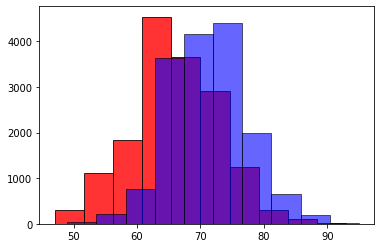

In [29]:
plt.hist(pd_fifa_movement_new.overall, alpha=0.8, histtype='bar', color='red',ec='black')
plt.hist(pd_fifa_movement_new.potential, alpha=0.6, histtype='bar', color='blue',ec='black')

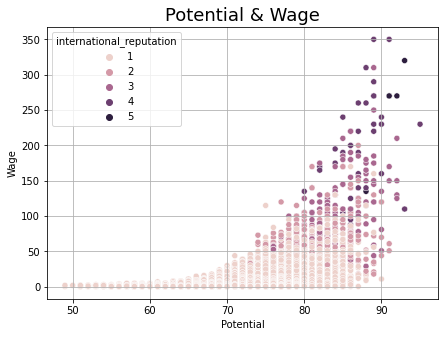

In [30]:
plt.figure(figsize=(7, 5))
plt.grid()
plt.rcParams['axes.facecolor'] = 'white'
ax = sb.scatterplot(x =pd_fifa_movement_new['potential'], y = pd_fifa_movement_new['Wage_in_K'], hue = pd_fifa_movement_new['international_reputation'])
plt.xlabel("Potential") 
plt.ylabel("Wage")
plt.title("Potential & Wage", fontsize = 18)
plt.show()

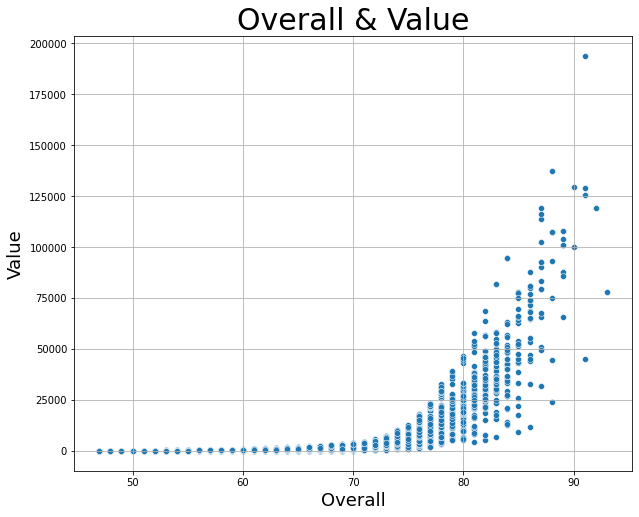

In [31]:
plt.figure(figsize=(10, 8))
plt.grid()
plt.rcParams['axes.facecolor'] = 'white'
ax = sb.scatterplot(x =pd_fifa_movement_new['overall'], y = pd_fifa_movement_new['Value_in_K'])
plt.xlabel("Overall",fontsize = 18) 
plt.ylabel("Value",fontsize = 18)
plt.title("Overall & Value", fontsize = 30)
plt.show()

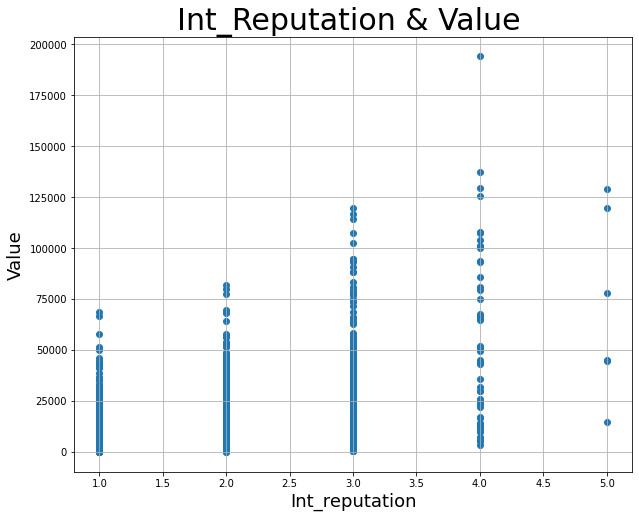

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
plt.grid()
plt.rcParams['axes.facecolor'] = 'black'
plt.scatter(x=pd_fifa_movement_new['international_reputation'], y=pd_fifa_movement_new["Value_in_K"] )
plt.xlabel("Int_reputation",fontsize=18) 
plt.ylabel("Value",fontsize=18)
plt.title("Int_Reputation & Value ", fontsize = 30)
plt.show()

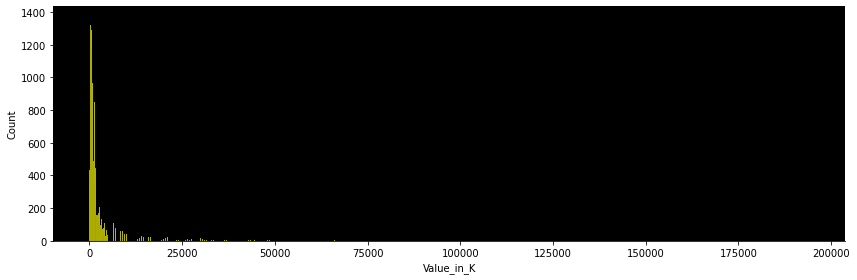

In [33]:
plt.rcParams['axes.facecolor'] = 'black'

value_plot= sb.displot(pd_fifa_movement_new['Value_in_K'],height=4,aspect=3,color='yellow') 


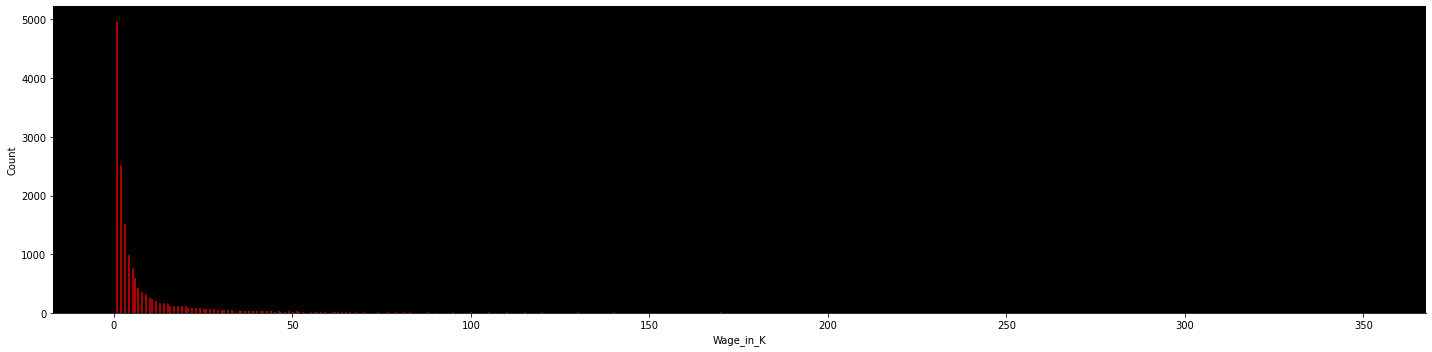

In [34]:
wage_plot= sb.displot(pd_fifa_movement_new['Wage_in_K'],height=5,aspect=4,color='red') 


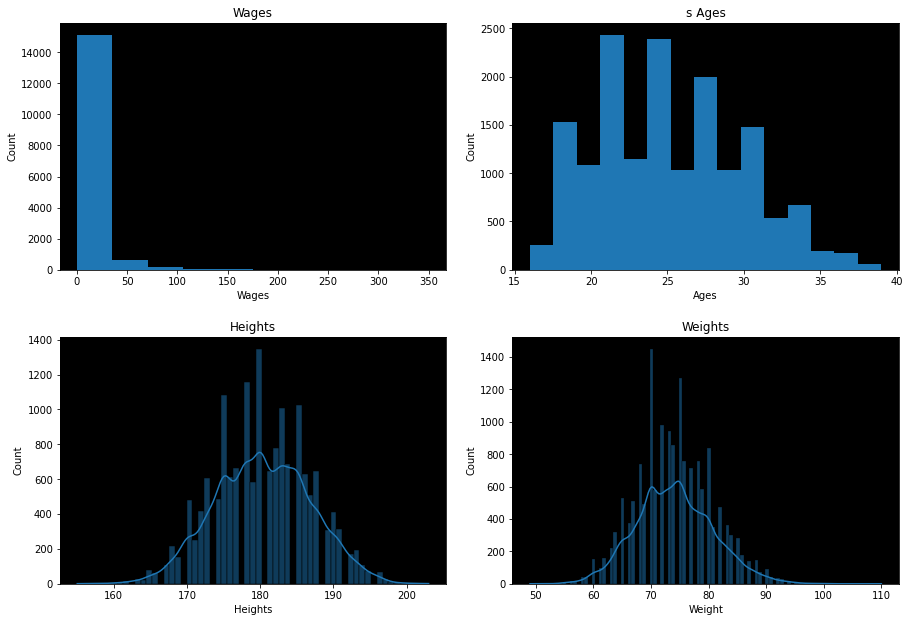

In [35]:

fig, axes = plt.subplots(2, 2, figsize=(13, 9))
plt.grid()
axes[0,0].hist(pd_fifa_movement_new['Wage_in_K'])
axes[0,0].set_xlabel('Wages')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Wages')

axes[0,1].hist(pd_fifa_movement_new['age'], bins = 15)
plt.grid()
axes[0,1].set_xlabel('Ages')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('s Ages')

# first two is using a matplotlib syntax, the next two I'll do with seaborn 

axes[1,0].set_title('Heights')
plt.grid()
sb.histplot(pd_fifa_movement_new, x='height_cm', ax=axes[1,0], kde=True)
axes[1,0].set_xlabel('Heights')
axes[1,0].set_ylabel('Count')


axes[1,1].set_title('Weights')
plt.grid()
sb.histplot(pd_fifa_movement_new, x='weight_kg', ax=axes[1,1], kde=True)
axes[1,1].set_xlabel('Weight')
axes[1,1].set_ylabel('Count')


plt.tight_layout(pad=2)
plt.show()


# Encoding, vectorAssembler and Linear Regression 

#### Faccio un primo assembler per il modello ad una sola variabile --> movement_reactions

<AxesSubplot:>

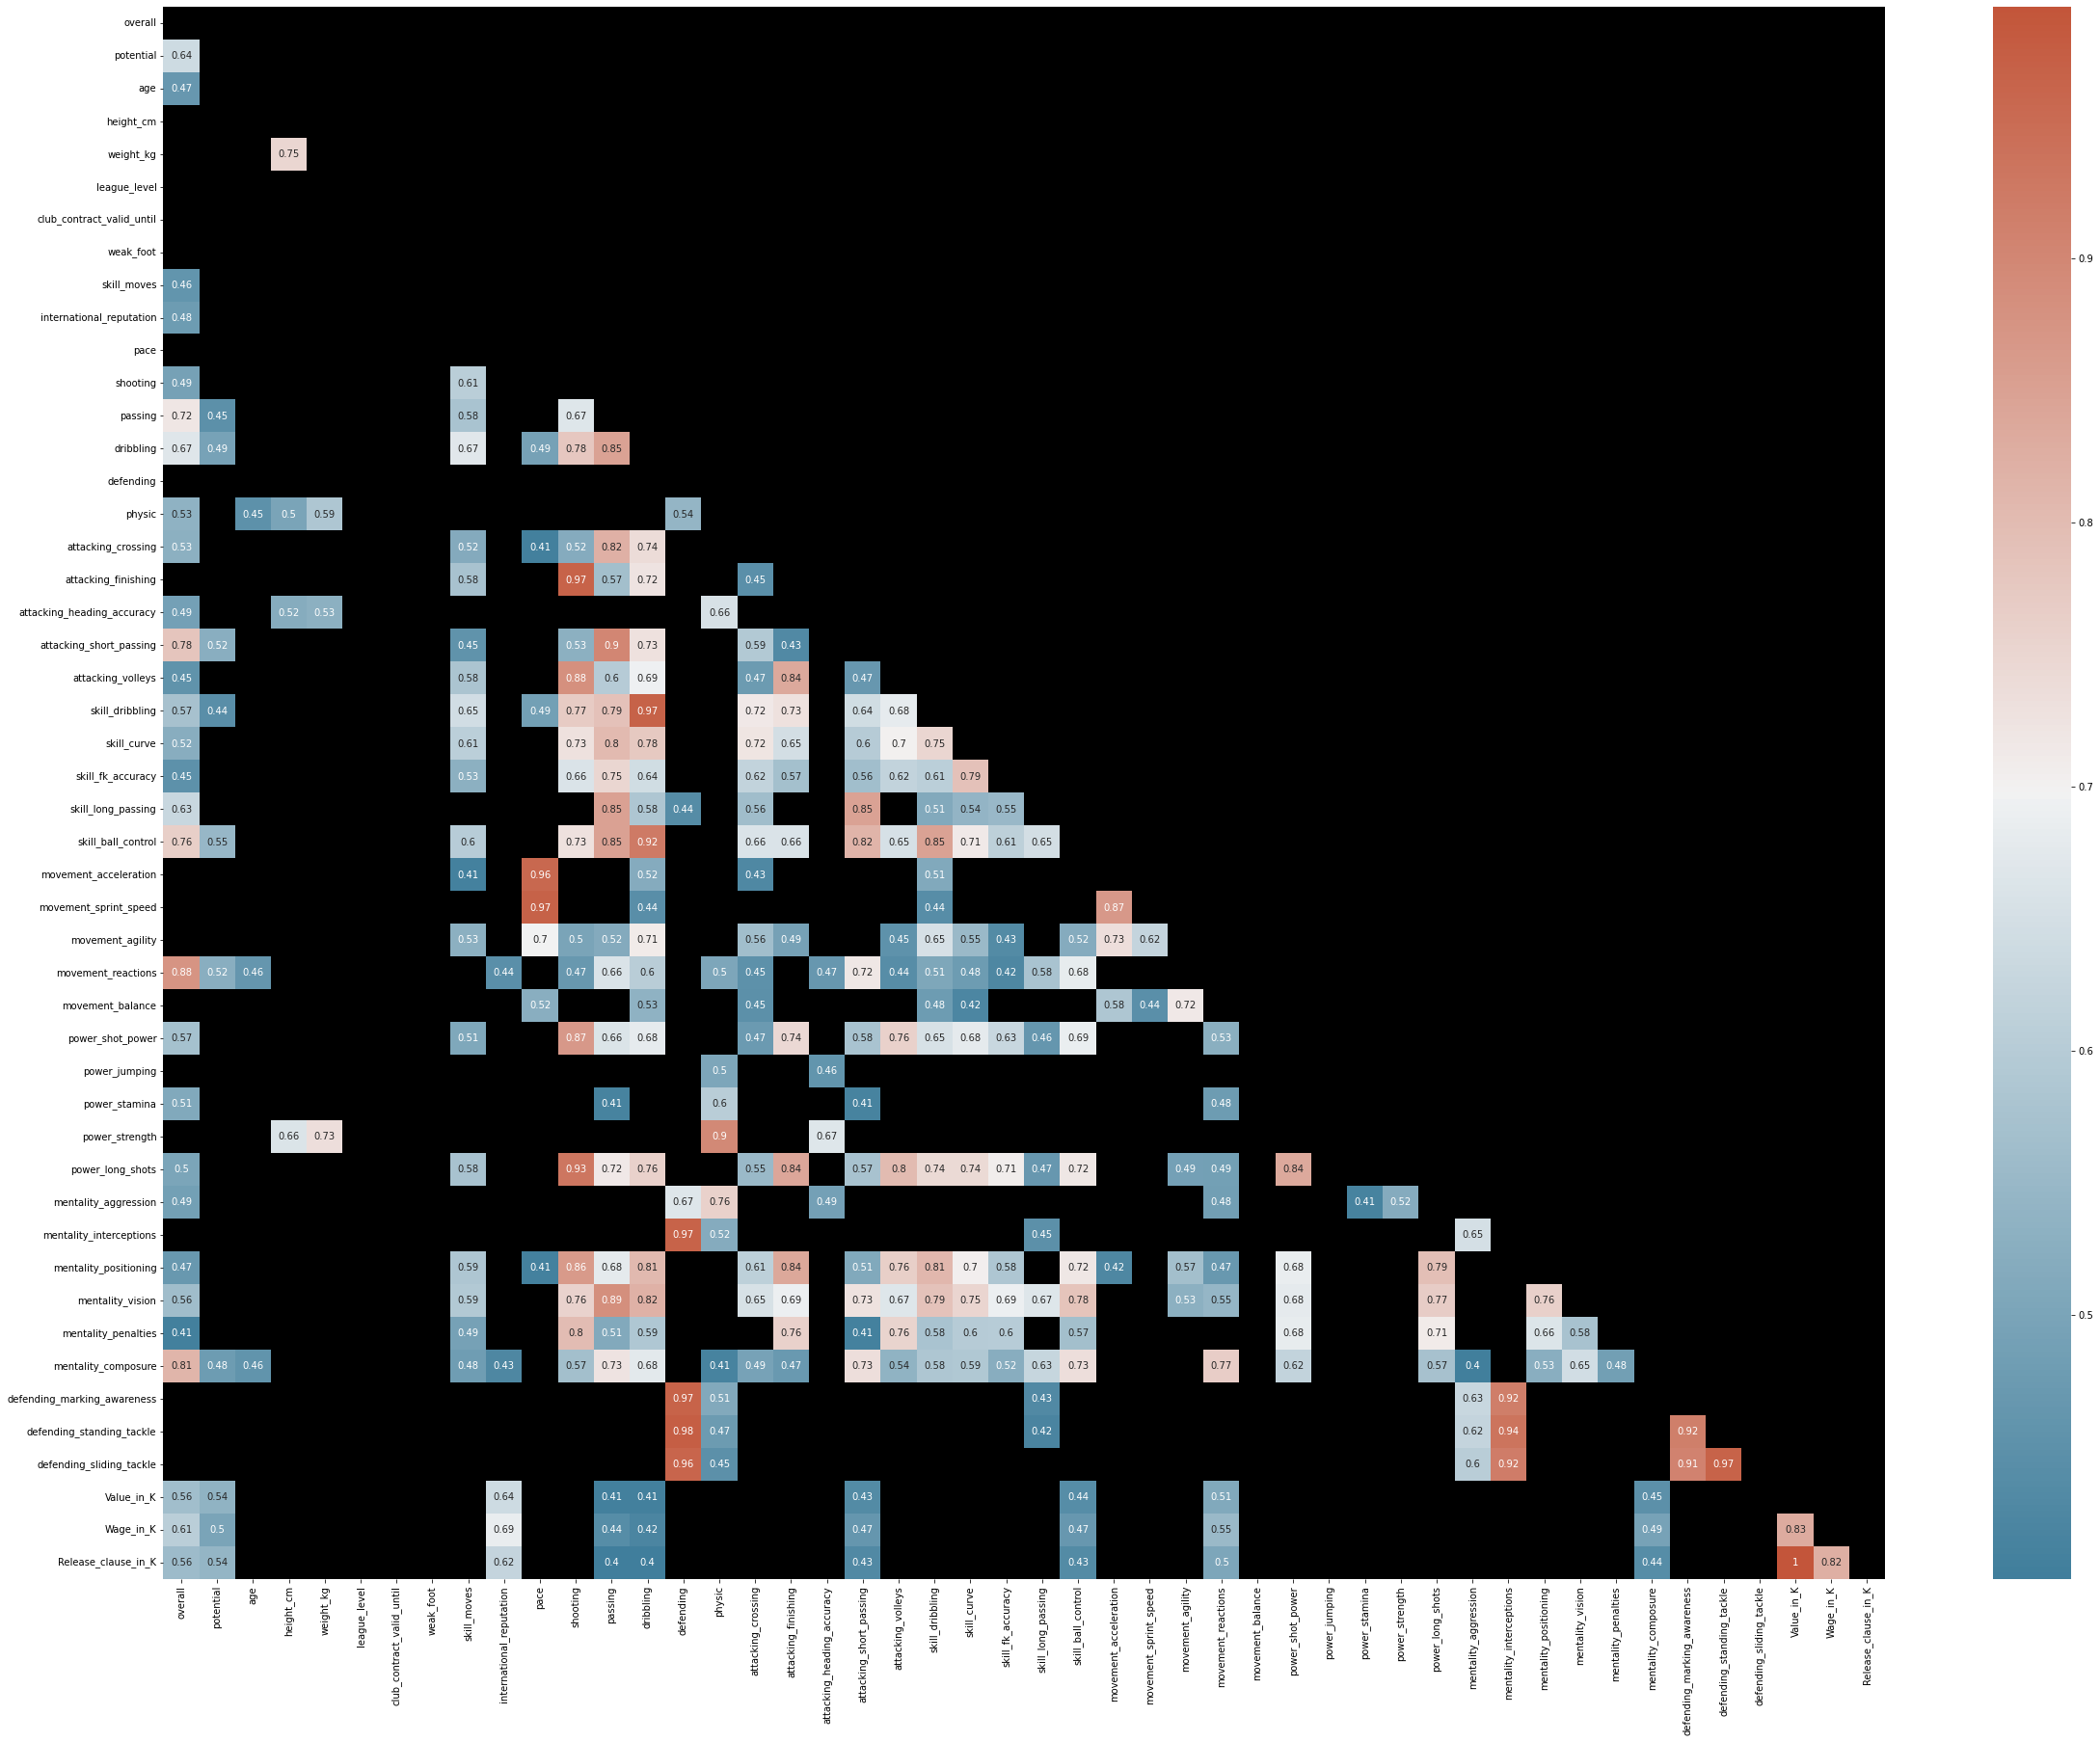

In [36]:
  
corr= pd_fifa_movement_new.corr().where(pd_fifa_movement_new.corr()>0.4)
f, ax = plt.subplots(figsize=(40, 30))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sb.diverging_palette(230, 20, as_cmap=True)
sb.heatmap(corr, annot=True, mask = mask, cmap=cmap,annot_kws={"size":10})

Costruisco un modello solo con overall and movement_reactions per scoprire quanto sia capace di descrivere l'overall

In [37]:
data_model_1v=fifa_data_movement_new.select("overall","movement_reactions")

In [38]:
Assembler_1v = VectorAssembler(inputCols=["movement_reactions"], outputCol='movement_reactions_ass')
data_enc_1v=Assembler_1v.transform(data_model_1v)

In [39]:
data_enc_1v=data_enc_1v.drop("movement_reactions")

In [40]:
data_enc_1v.show()

+-------+----------------------+
|overall|movement_reactions_ass|
+-------+----------------------+
|     93|                [94.0]|
|     92|                [93.0]|
|     91|                [94.0]|
|     91|                [89.0]|
|     91|                [91.0]|
|     91|                [93.0]|
|     90|                [92.0]|
|     90|                [93.0]|
|     89|                [91.0]|
|     89|                [91.0]|
|     89|                [87.0]|
|     89|                [87.0]|
|     89|                [91.0]|
|     89|                [92.0]|
|     89|                [88.0]|
|     88|                [92.0]|
|     88|                [92.0]|
|     88|                [90.0]|
|     88|                [91.0]|
|     88|                [90.0]|
+-------+----------------------+
only showing top 20 rows



In [41]:
train_1v,test_1v = data_enc_1v.randomSplit([0.7, 0.3],seed=13)

pd_train_1v=train_1v.toPandas()
pd_test_1v=test_1v.toPandas()



In [42]:
L_R_1v = LinearRegression(featuresCol ='movement_reactions_ass',labelCol='overall') 


L_R_1v_model = L_R_1v.fit(train_1v)
trainingSummary_1v = L_R_1v_model.summary

print("Risultati sul Train")
print("RMSE: %f" % trainingSummary_1v.rootMeanSquaredError)
print("r2: %f" % trainingSummary_1v.r2)
train_1v.describe().show()

print("Risultati sul Test")

test_result_1v = L_R_1v_model.evaluate(test_1v)

print("RMSE = %g" % test_result_1v.rootMeanSquaredError)
print("r2 = %g" % test_result_1v.r2)
test_1v.describe().show()


22/06/28 00:50:18 WARN Instrumentation: [38ca94c7] regParam is zero, which might cause numerical instability and overfitting.
22/06/28 00:50:18 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/06/28 00:50:18 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/06/28 00:50:18 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Risultati sul Train
RMSE: 3.281636
r2: 0.769728
+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|             11198|
|   mean| 65.88337203071977|
| stddev|6.8389509274179705|
|    min|                47|
|    max|                93|
+-------+------------------+

Risultati sul Test
RMSE = 3.31403
r2 = 0.762649
+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|              4822|
|   mean| 65.85420987142264|
| stddev|6.8030720993935745|
|    min|                47|
|    max|                92|
+-------+------------------+



## Encoding and vectorassembler

#### Qui osservo che le variabili relative ad i valori dei giocatori in ciascuna delle posizioni sono stringhe con "+ o -" al loro interno, passo quindi alla correzione al solo primo valore indicato tramite una regex e codifico tutte queste variabili come integer.

In [43]:
fifa_data_movement_new.printSchema()

root
 |-- short_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_name: string (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullabl

In [44]:
fifa_data_movement_new.select("ls",'st','rs',"lw","lf","cf","rf","rw",
 'lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm',
 'cdm','rdm','rwb','lb','lcb',"cb","rcb","rb").show()

+----+----+----+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  ls|  st|  rs| lw| lf| cf| rf| rw| lam| cam| ram|  lm| lcm|  cm| rcm|  rm| lwb| ldm| cdm| rdm| rwb|  lb| lcb|  cb| rcb|  rb|
+----+----+----+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|89+3|89+3|89+3| 92| 93| 93| 93| 92|  93|  93|  93|91+2|87+3|87+3|87+3|91+2|66+3|64+3|64+3|64+3|66+3|61+3|50+3|50+3|50+3|61+3|
|90+2|90+2|90+2| 85| 88| 88| 88| 85|86+3|86+3|86+3|84+3|80+3|80+3|80+3|84+3|64+3|66+3|66+3|66+3|64+3|61+3|60+3|60+3|60+3|61+3|
|90+1|90+1|90+1| 88| 89| 89| 89| 88|86+3|86+3|86+3|86+3|78+3|78+3|78+3|86+3|63+3|59+3|59+3|59+3|63+3|60+3|53+3|53+3|53+3|60+3|
|83+3|83+3|83+3| 90| 88| 88| 88| 90|89+2|89+2|89+2|89+2|82+3|82+3|82+3|89+2|67+3|63+3|63+3|63+3|67+3|62+3|50+3|50+3|50+3|62+3|
|83+3|83+3|83+3| 88| 87| 87| 87| 88|89+2|89+2|89+2|89+2|89+2|89+2|89+2|89+2|79+3|80+3|80+3|80+3|79+3|75+3|69+3|

In [47]:
for i in pd_fifa_movement_new.ls.unique() :
    print (i,re.sub(rf"[+ or -].*","",i))

89+3 89
90+2 90
90+1 90
83+3 83
88+2 88
72+3 72
87+2 87
85+3 85
76+3 76
70+3 70
86+3 86
77+3 77
87+1 87
81+3 81
87+3 87
86+1 86
79+3 79
82+3 82
71+3 71
84+3 84
78+3 78
75+3 75
61+3 61
57+3 57
74+3 74
77+2 77
56+3 56
66+3 66
84+2 84
80+3 80
60+3 60
65+3 65
84+1 84
83+2 83
59+3 59
70+2 70
79+2 79
78+2 78
68+3 68
83+1 83
75+2 75
69+2 69
72+2 72
82+2 82
74+2 74
84 84
67+3 67
54+2 54
71+2 71
58+2 58
63+3 63
82+1 82
64+3 64
73+3 73
52+3 52
62+2 62
83 83
67+2 67
61+2 61
76+2 76
81+2 81
80+2 80
63+2 63
62+3 62
54+3 54
82 82
73+2 73
81+1 81
66+2 66
60+2 60
64+2 64
81 81
80+1 80
69+3 69
68+2 68
59+2 59
53+2 53
65+2 65
52+2 52
80 80
57+2 57
79+1 79
55+2 55
56+2 56
49+2 49
79 79
78+1 78
77+1 77
78 78
79-1 79
51+2 51
77 77
76+1 76
50+2 50
58+3 58
75+1 75
76 76
46+2 46
48+2 48
75 75
76-1 76
74+1 74
50+3 50
44+2 44
74 74
73+1 73
47+2 47
75-1 75
45+2 45
74-1 74
72+1 72
73 73
48+3 48
72 72
73-1 73
55+3 55
41+2 41
71+1 71
74-2 74
71 71
45+3 45
72-1 72
70+1 70
73-2 73
70 70
42+2 42
69+1 69
43+2 43
71-1 7

In [48]:
list_role =["ls",'st','rs',"lw","lf","cf","rf","rw",
 'lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm',
 'cdm','rdm','rwb','lb','lcb',"cb","rcb","rb"]
for i in fifa_data_movement_new.columns :
    if i in list_role :
        fifa_data_movement_new= fifa_data_movement_new.withColumn(i+"_new",regexp_replace(i,"[+ or -].*",""))
    

In [49]:
new_list_role=["ls_new",'st_new','rs_new',"lw_new","lf_new","cf_new","rf_new","rw_new",
 'lam_new','cam_new','ram_new','lm_new','lcm_new','cm_new','rcm_new','rm_new','lwb_new','ldm_new',
 'cdm_new','rdm_new','rwb_new','lb_new','lcb_new',"cb_new","rcb_new","rb_new"]

 


In [50]:
for i in fifa_data_movement_new.columns :
    if i in new_list_role :
        fifa_data_movement_new = fifa_data_movement_new.withColumn(i, fifa_data_movement_new[i].cast("integer"))
  

In [51]:
fifa_data_movement_new=fifa_data_movement_new.drop("ls","st","rs","lw","lf","cf","rf","rw","lam","cam",
                                                  "ram","lm","lcm","cm","rcm","rm","lwb","ldm","cdm","rdm",
                                                  "rwb","lb","lcb","cb","rcb","rb")


In [52]:
fifa_data_movement_new.printSchema()

root
 |-- short_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_name: string (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullabl

In [53]:
fifa_data_movement_new.select("ls_new",'st_new','rs_new',
 'lam_new','cam_new','ram_new','lm_new','lcm_new','cm_new','rcm_new','rm_new','lwb_new','ldm_new',
 'cdm_new','rdm_new','rwb_new','lb_new','lcb_new').show()

+------+------+------+-------+-------+-------+------+-------+------+-------+------+-------+-------+-------+-------+-------+------+-------+
|ls_new|st_new|rs_new|lam_new|cam_new|ram_new|lm_new|lcm_new|cm_new|rcm_new|rm_new|lwb_new|ldm_new|cdm_new|rdm_new|rwb_new|lb_new|lcb_new|
+------+------+------+-------+-------+-------+------+-------+------+-------+------+-------+-------+-------+-------+-------+------+-------+
|    89|    89|    89|     93|     93|     93|    91|     87|    87|     87|    91|     66|     64|     64|     64|     66|    61|     50|
|    90|    90|    90|     86|     86|     86|    84|     80|    80|     80|    84|     64|     66|     66|     66|     64|    61|     60|
|    90|    90|    90|     86|     86|     86|    86|     78|    78|     78|    86|     63|     59|     59|     59|     63|    60|     53|
|    83|    83|    83|     89|     89|     89|    89|     82|    82|     82|    89|     67|     63|     63|     63|     67|    62|     50|
|    83|    83|    83|     

In [54]:
pd_fifa_movement_new.league_level.describe()

count    16020.000000
mean         1.345131
std          0.739188
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: league_level, dtype: float64

In [55]:
pd_fifa_movement_new=fifa_data_movement_new.toPandas()

##### Indicizzo e codifico la variabile work_rate

In [56]:
pd_fifa_movement_new.work_rate.unique()

array(['Medium/Low', 'High/Medium', 'High/Low', 'High/High',
       'Medium/High', 'Medium/Medium', 'Low/High', 'Low/Medium',
       'Low/Low'], dtype=object)

In [57]:
Indexer = StringIndexer(inputCol=('work_rate'), 
                        outputCol=('work_rate_NDX'))

In [58]:
OHEncoder = OneHotEncoder(inputCol='work_rate_NDX',
                        outputCol='work_rate_OHE')

#### Preparo il modello con solo le i valori relativi ai ruoli

In [59]:
fifa_data_movement_new.printSchema()

root
 |-- short_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_name: string (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullabl

In [60]:
data_ruoli=fifa_data_movement_new.select("overall",'ls_new',
                 'st_new', 'rs_new', 'lw_new', 'lf_new', 'cf_new', 'rf_new', 'rw_new',
                  'lam_new', 'cam_new', 'ram_new',
                 'lm_new', 'lcm_new', 'cm_new', 'rcm_new', 'rm_new', 'lwb_new', 'ldm_new',
                  'cdm_new', 'rdm_new', 'rwb_new',
                 'lb_new', 'lcb_new', 'cb_new', 'rcb_new', 'rb_new')

In [61]:
feature_col_rol=['ls_new',
                 'st_new', 'rs_new', 'lw_new', 'lf_new', 'cf_new', 'rf_new', 'rw_new',
                  'lam_new', 'cam_new', 'ram_new',
                 'lm_new', 'lcm_new', 'cm_new', 'rcm_new', 'rm_new', 'lwb_new', 'ldm_new',
                  'cdm_new', 'rdm_new', 'rwb_new',
                 'lb_new', 'lcb_new', 'cb_new', 'rcb_new', 'rb_new']



In [62]:
Assembler_ruoli=VectorAssembler(inputCols=feature_col_rol, outputCol='features_rol')

In [63]:
data_rol=Assembler_ruoli.transform(data_ruoli)

In [64]:
train_rol,test_rol = data_rol.randomSplit([0.7, 0.3],seed=13)
pd_train_rol=train_rol.toPandas()
pd_test_rol=test_rol.toPandas()




In [65]:
L_R_rol = LinearRegression(featuresCol ='features_rol',labelCol='overall') 


L_R_rol_model = L_R_rol.fit(train_rol)
trainingSummary_rol = L_R_rol_model.summary

print("Risultati sul Train")
print("RMSE: %f" % trainingSummary_rol.rootMeanSquaredError)
print("r2: %f" % trainingSummary_rol.r2)
train_rol.describe("overall").show()
#train_rol.describe().show()

print("Risultati sul Test")

test_result_rol = L_R_rol_model.evaluate(test_rol)

print("RMSE = %g" % test_result_rol.rootMeanSquaredError)
print("r2 = %g" % test_result_rol.r2)
test_rol.describe("overall").show()
#test_rol.describe().show()

22/06/28 00:51:20 WARN Instrumentation: [d2b5455f] regParam is zero, which might cause numerical instability and overfitting.
22/06/28 00:51:20 WARN Instrumentation: [d2b5455f] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Risultati sul Train
RMSE: 3.137135
r2: 0.789561


+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|             11198|
|   mean| 65.88337203071977|
| stddev|6.8389509274179705|
|    min|                47|
|    max|                93|
+-------+------------------+

Risultati sul Test
RMSE = 3.14278
r2 = 0.786545
+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|              4822|
|   mean| 65.85420987142264|
| stddev|6.8030720993935745|
|    min|                47|
|    max|                92|
+-------+------------------+



#### Prepraro il modello con più variabili

In [66]:
feature_col=["Value_in_K","potential","age","height_cm",
                 "weight_kg","league_level",
                 "weak_foot","skill_moves","club_contract_valid_until",
                "international_reputation","pace","shooting","passing",
                "dribbling","defending","physic","attacking_crossing",
                "attacking_finishing","attacking_heading_accuracy",
                 "attacking_short_passing",'attacking_volleys','skill_dribbling',
                 'skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control',
                 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
                 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping',
                 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression',
                 'mentality_interceptions','mentality_positioning','mentality_vision',
                 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness',
                 'defending_standing_tackle', 'defending_sliding_tackle', 'ls_new',
                 'st_new', 'rs_new', 'lw_new', 'lf_new', 'cf_new', 'rf_new', 'rw_new',
                  'lam_new', 'cam_new', 'ram_new',
                 'lm_new', 'lcm_new', 'cm_new', 'rcm_new', 'rm_new', 'lwb_new', 'ldm_new',
                  'cdm_new', 'rdm_new', 'rwb_new',
                 'lb_new', 'lcb_new', 'cb_new', 'rcb_new', 'rb_new', 'Wage_in_K', 'Release_clause_in_K']

In [67]:
Assembler = VectorAssembler(inputCols=feature_col, outputCol='features')

#### Scalo le features

In [68]:
rb_scaler = RobustScaler(inputCol='features', outputCol='featuresRB')


In [69]:
Assembler_2 = VectorAssembler(inputCols=("featuresRB",'work_rate_OHE'), outputCol='new_featuresRB')

In [70]:
pipeline = Pipeline(stages=[Indexer,OHEncoder, Assembler,rb_scaler,Assembler_2]) 

In [71]:
data_enc = pipeline.fit(fifa_data_movement_new).transform(fifa_data_movement_new)

In [72]:
pd_data_enc=data_enc.toPandas()


In [73]:
data_enc.select("potential","work_rate_OHE","value_in_K","features").show(10)

+---------+-------------+----------+--------------------+
|potential|work_rate_OHE|value_in_K|            features|
+---------+-------------+----------+--------------------+
|       93|(8,[5],[1.0])|   78000.0|[78000.0,93.0,34....|
|       92|(8,[1],[1.0])|  119500.0|[119500.0,92.0,32...|
|       91|(8,[4],[1.0])|   45000.0|[45000.0,91.0,36....|
|       91|(8,[1],[1.0])|  129000.0|[129000.0,91.0,29...|
|       91|(8,[3],[1.0])|  125500.0|[125500.0,91.0,30...|
|       95|(8,[4],[1.0])|  194000.0|[194000.0,95.0,22...|
|       90|(8,[3],[1.0])|  129500.0|[129500.0,90.0,27...|
|       90|(8,[2],[1.0])|  100000.0|[100000.0,90.0,30...|
|       89|(8,[0],[1.0])|   66000.0|[66000.0,89.0,33....|
|       89|(8,[3],[1.0])|  104000.0|[104000.0,89.0,28...|
+---------+-------------+----------+--------------------+
only showing top 10 rows



In [74]:
data_model=data_enc.select("overall","new_featuresRB")

## Create train and test set

In [75]:
train_df,test_df = data_model.randomSplit([0.7, 0.3],seed=13)

## Linear Regression

### Modello con quasi tutte le variabili

In [76]:
L_R_O = LinearRegression(featuresCol ='new_featuresRB',labelCol='overall') 


In [77]:
L_R_model = L_R_O.fit(train_df)
trainingSummary = L_R_model.summary

22/06/28 00:51:35 WARN Instrumentation: [9ba6bfd4] regParam is zero, which might cause numerical instability and overfitting.
22/06/28 00:51:36 WARN Instrumentation: [9ba6bfd4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [78]:
print("Risultati sul Train")
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
train_df.describe().show()

test_result = L_R_model.evaluate(test_df)
test_result.r2
print("Risultati sul Test")
print("RMSE = %g" % test_result.rootMeanSquaredError)
print("r2 = %g" % test_result.r2)
test_df.describe().show()

Risultati sul Train
RMSE: 1.650606
r2: 0.941743
+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|             11198|
|   mean| 65.88337203071977|
| stddev|6.8389509274179705|
|    min|                47|
|    max|                93|
+-------+------------------+

Risultati sul Test
RMSE = 1.66817
r2 = 0.939861
+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|              4822|
|   mean| 65.85420987142264|
| stddev|6.8030720993935745|
|    min|                47|
|    max|                92|
+-------+------------------+

